# Modèle non linéaire - Accelerated Sinkhorn RNA

Ici on reprend tout ce qu'on a fait, mais on change la loss.
On utilise la distance de Wasserstein (transport optimal), calculé par un algorithme de Sinkorhn. 
On veut transpoter une distribution a en b.

We consider (for stabilization purpose)
the variables $f = \epsilon \log(u/a)$ and $g = \epsilon \log(v/b)$.
In these variables, Sinkhorn algorithm can be interpreted as an alternate maximization algorithm, to solve the following "dual" problem:
$$
\max_{f\in R^n, g \in R^m} F(f,g) =  \sum_{i=1}^n f_i a_i + \sum_{j=1}^m g_j b_j - \epsilon \sum_{i,j} a_ib_j \exp \left( (f_i + g_j -C_{ij})/\epsilon \right).
$$

In these variables, the algorithm is initialized with $g = 0_m$ and the updates read
$$
f_i \longleftarrow - \epsilon \log \sum_{j} b_j \exp ((g_j - C_{ij})/\epsilon),\, \forall i \\
g_j \longleftarrow - \epsilon \log \sum_{i} a_i \exp ((f_i - C_{ij})/\epsilon),\, \forall j
$$

The optimal transport plan $P=(P_{ij})_{\substack{i=1\dots n\\j=1\dots m}}$ can be recovered as 
$$
P_{ij} = a_ib_j\exp\left( (f_i+g_j - C_{ij})/\epsilon \right).
$$

On voit tout de suite une difficulté :

- The Gibbs kernel K is a Gaussian convolution,
$$ 
\begin{cases}
C_{i,j} = i/N-j/N)^2 , \\
 K_{i,j} = e^{ -(i/N-j/N)^2/\epsilon }, 
\end{cases}
 $$
et est indépendant de a et b

- Le coût final est 
$$ W = \langle P,C \rangle $$ 
la loss sera donc calculée à partir des dérivées des plan de transport u et v.
En effet
$$
\begin{split}
\frac{\partial W}{\partial a} = & \frac{\partial \langle P,C \rangle}{\partial a} \\ 
                = &  \langle\frac{\partial \text{exp} (-C_{ij} + u_i + v_j) / \epsilon) }{\partial a}, C \rangle \\
                = &  \langle\frac{\partial \text{exp} (u_i) / \epsilon) }{\partial a}, C \rangle 
                 + \langle\frac{\partial \text{exp} (v_j) / \epsilon) }{\partial a}, C \rangle \\
\end{split}
$$
Et donc à travers toutes les itérations... d'où le besoin d'accélérer l'algo.

## Importation

In [2]:
import numpy as np
# pytorch
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torch.nn.modules.loss import _Loss
import torch
from torch.autograd import Variable
# matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Data

In [3]:
# Physical data
l = 1
tau = 1
dep = 1
# Numerical data
nx = 200
dx = l/(nx+1)
nt = 200
dt = tau/nt
T_operator = 1/100*dx*np.tri(nt, nx, 0, dtype=int)
# Data sample
nsamp = 400
x_dagger = np.zeros((nsamp,nx))
y = np.zeros((nsamp,nt))
x_grid = np.linspace(0,l,nx)
#
x_sample = np.zeros((nsamp,nx))
#
for i in range(0,nsamp):
    mu = l/2
    sigma = 10*l
    x_dagger[i] = (sigma*np.sqrt(2*np.pi))**-1*np.exp(-(x_grid-mu)**2/2*sigma**2)
    x_dagger[i] = x_dagger[i]/x_dagger[i].sum()
    y[i] = T_operator.dot(x_dagger[i]) 
    xi = np.random.uniform(-0.005,0.005,nt)
    y[i] += xi*np.linalg.norm(y[i])/np.linalg.norm(xi)
    x_sample[i] = np.transpose(T_operator).dot(y[i])

In [4]:
# Regularisation operator
D_operator = np.diag(np.ones(nx-1),1)+ np.diag(np.ones(nx-1),-1)-2*np.eye(nx)

In [5]:
x_tensor = torch.from_numpy(x_sample)
y_tensor = torch.from_numpy(x_dagger)

dataset = TensorDataset(x_tensor, y_tensor)

train_dataset, val_dataset = random_split(dataset, [300, 100])

train_loader = DataLoader(dataset=train_dataset, batch_size=5)
val_loader = DataLoader(dataset=val_dataset, batch_size=5)

## Loss

In [87]:
class My_loss(_Loss):
    def __init__(self): 
        super(My_loss, self).__init__()
        self.epsilon = 0.001
        self.niter = 1000
 
    def forward(self, output, target):
        computed_loss = sinkhorn_loss(output, target, self.epsilon, self.niter)
        return computed_loss

In [88]:
loss_fn = My_loss()

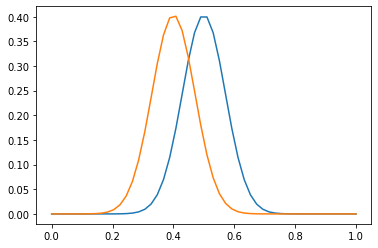

In [89]:
tt = np.linspace(0,1,50)
a = np.exp(-(tt-0.5)**2/0.01)
a = a/np.linalg.norm(a)
b = np.exp(-(tt-0.4)**2/0.01)
b = b/np.linalg.norm(b)
plt.plot(tt,a)
plt.plot(tt,b)

In [90]:
loss_fn(torch.FloatTensor(a),torch.FloatTensor(b))

tensor(inf, dtype=torch.float64)

In [ ]:
### TEST NUMPY

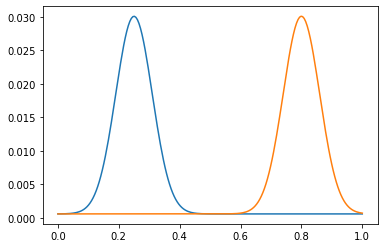

In [108]:
t = np.linspace(0,1,200)
Gaussian = lambda t0,sigma: np.exp(-(t-t0)**2/(2*sigma**2))
normalize = lambda p: p/np.sum(p)

sigma = .06;
a = Gaussian(.25,sigma)
b = Gaussian(.8,sigma)

vmin = .02;
a = normalize( a+np.max(a)*vmin)
b = normalize( b+np.max(b)*vmin)
N = 200
[Y,X] = np.meshgrid(t,t)
C = (X-Y)**2
plt.plot(t,a)
plt.plot(t,b)

In [106]:
def sinkhorn_log(epsilon, niter):
    f = np.zeros(N)
    g = np.zeros(N)
    dual_obj = []
    errs = []
    for i in range(niter):
        # we stabilize the log-sum-exp operations by taking the maximum
        Mf = g.reshape(1,-1) - C
        Mf_max = np.max(Mf, axis = 1)
        f = - Mf_max - epsilon*np.log(np.sum( b.reshape(1,-1) * np.exp((Mf - Mf_max.reshape(-1,1))/epsilon), axis=1))
        
        Mg =  f.reshape(-1,1) - C
        Mg_max = np.max(Mg, axis = 0)
        g = - Mg_max- epsilon*np.log(np.sum( a.reshape(-1,1) * np.exp((Mg - Mg_max.reshape(1,-1))/epsilon), axis=0))
        
    P =  np.sum(a.reshape(-1,1)*b.reshape(1,-1)*np.exp((f.reshape(-1,1) + g.reshape(1,-1) - C)/epsilon))
    return P

In [107]:
sinkhorn_log(0.1, 100)

0.9999999999999997